In [3]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(mltools)
library(data.table)
library(VIM)
library(lubridate)
library(caret)
library(CatEncoders)
library(ROSE)
library(catboost)
library(UBL)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(jsonlite)
library(stringr)
library(feather)
#group_by
library(dplyr)
#plot, ggplot
library(ggplot2)
library(ggpubr)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files
#assign correct data types and appropriate column names 
col_types <- cols(
  channelGrouping = col_character(),
  customDimensions = col_character(),
  date = col_datetime(), # Parses YYYYMMDD
  #date = col_integer(), #lets do the conversion later after ROSE
  device = col_character(),
  fullVisitorId = col_character(),
  geoNetwork = col_character(),
  hits = col_skip(), # MASSIVE amount of data!
  #sessionId = col_character(), # not present in v2 comp; not used anwyay
  socialEngagementType = col_skip(), # Skip as always "Not Socially Engaged"
  totals = col_character(),
  trafficSource = col_character(),
  visitId = col_integer(), # visitId & visitStartTime look identical in all but 5000 cases
  visitNumber = col_integer(),
  visitStartTime = col_integer() # Convert to POSIXlt later,
  #visitStartTime = col_datetime()
  )
# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")
train <- read_csv("../input/ga-customer-revenue-prediction/train_v2.csv", col_types = col_types) 
test <- read_csv("../input/ga-customer-revenue-prediction/test_v2.csv",  col_types = col_types)

#which columns includes JSON, JSON-like data
#JSON columns are "device", "geoNetwork", "totals", "trafficSource", "customDimensions"
unsnake <- . %>%
  str_replace_all(c("\\[\\]" = "[{}]", # empty element must contain dictionary
                    "^\\[|\\]$" = "", # remove initial and final brackets
                    "(\\[|\\{|, |: |', )'" = "\\1\"", # open single- to double-quote (on key or value)
                    "'(\\]|\\}|: |, )" = '\"\\1')) # close quote

tr_device <- paste("[", paste(train$device, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_geoNetwork <- paste("[", paste(train$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_totals <- paste("[", paste(train$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_trafficSource <- paste("[", paste(train$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

tr_customDimensions <- paste("[", paste(unsnake(train$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

te_device <- paste("[", paste(test$device, collapse = ","), "]") %>% fromJSON(flatten = T)
te_geoNetwork <- paste("[", paste(test$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
te_totals <- paste("[", paste(test$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
te_trafficSource <- paste("[", paste(test$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

te_customDimensions <- paste("[", paste(unsnake(test$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

#Combine to make the full training and test sets. campaignCode in train is dropped.
flat.train <- train %>%
    cbind(tr_device, tr_geoNetwork, tr_totals, tr_trafficSource, tr_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions, -campaignCode)
    
flat.test <- test %>%
    cbind(te_device, te_geoNetwork, te_totals, te_trafficSource, te_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions)

#Remove temporary tr_ and te_ sets
rm(tr_device); rm(tr_geoNetwork); rm(tr_totals); rm(tr_trafficSource); rm(tr_customDimensions)
rm(te_device); rm(te_geoNetwork); rm(te_totals); rm(te_trafficSource); rm(te_customDimensions)

flat.train.red <- flat.train %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index)

flat.test.red <- flat.test %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index)

#setequal(names(flat.train.red), names(flat.test.red))
## Saving data
#write.csv(flat.train.red, "train_flat.csv", row.names = F)
#write.csv(flat.test.red, "test_flat.csv", row.names = F)

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

In [49]:
print("Data preparation...")
#----------------------------------
dup_train <- flat.train.red
dup_test <- flat.test.red
# Combining train and test samples
dup_train <- rbind(dup_train, dup_test)
#attributes type conversion
dup_train$visitId <- as.character(dup_train$visitId)
# Numeric type conversion
cols.nam <- c("visitNumber", "visitStartTime", "hits","pageviews","sessionQualityDim","timeOnSite",
             "transactions","transactionRevenue","totalTransactionRevenue")
dup_train[cols.nam] <- sapply(dup_train[cols.nam],as.numeric)

# Removing near zero variance attributes 
nzv <- nearZeroVar(dup_train)
dup_train <- dup_train[, -nzv]

# Correlated attributes
train.cor <-  cor(select_if(dup_train, is.numeric), use = "complete.obs")
high.cor.att <- findCorrelation(train.cor, cutoff = .75, names=TRUE)#to drop pageviews and transactionRevenue
# pageviews and transactionRevenue highly correlated with hits and totalTransactionRevenue recpectively
# The dataset data dictionary also suggests using totalTransactionRevenue instead of transactionRevenue 
# as it is deprecated.
dup_train <- select(dup_train, -c(all_of(high.cor.att)))

[1] "Data preparation..."


In [50]:
print("Missing Values Ratio...")
#-----------------------------------------
funcMissRatio <- function(x, y){
    n <- vector()
    n <- rep(NA, length(x))
    missRatio <- cbind(x, n)

    for (i in 1:length(x)){
        y[x[i]][y[x[i]] == "(not set)"] <- NA
        y[x[i]][y[x[i]] == "not available in demo dataset"] <- NA
        y[x[i]][y[x[i]] == "unknown.unknown"] <- NA
        y[x[i]][y[x[i]] == "(none)"] <- NA
        y[x[i]][y[x[i]] == "(not provided)"] <- NA
        missRatio[i, 2] <- sum(is.na(y[x[i]]))/nrow(y)*100
    }
    print(missRatio)
    return(y)
}
# Start we geographical data as we will use it for further impute other attributes NAs, e.g., continent, subContinent
cols.nam <- c("continent", "subContinent", "country", "metro", "city", "region", "networkDomain")
dup_train <- funcMissRatio(cols.nam, dup_train)
#--------------------------------------------
print("Imputing NAs...")
#if all geo data are NA in the row
dup_train$continent[which(is.na(dup_train$networkDomain)&is.na(dup_train$city)& is.na(dup_train$metro)
    &is.na(dup_train$region)&is.na(dup_train$country) 
    &is.na(dup_train$continent)& is.na(dup_train$subContinent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#------------------------------------------
#region, city, networkDomain for some continent == NA are available
#from those we can extract continent value
temp <- dup_train %>%
    group_by(region) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$region)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$region)),
                                c("region")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.region.."))
nullatt <- rename(nullatt, c("region" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.region...."))

nullatt <- merge(temp, nullatt, by = c("region")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$region)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#------------------------------------------
temp <- dup_train %>%
    group_by(city) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$city)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$city)),
                                c("city")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.city.."))
nullatt <- rename(nullatt, c("city" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.city...."))

nullatt <- merge(temp, nullatt, by = c("city")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$city)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#-------------------------------------------
temp <- dup_train %>%
    group_by(networkDomain) %>%
    filter(!is.null(names(which.max(table(continent[!is.na(continent)]))))&!is.na(continent)) %>% #some networkDomain groups has no corresponding 
# continent result in NULL value, we filter them out to avoid error in summarize
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), 
                      dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), c("networkDomain")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.networkDomain.."))
nullatt <- rename(nullatt, c("networkDomain" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.networkDomain...."))

nullatt <- merge(temp, nullatt, by = c("networkDomain")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#----------------------------------------------
# The corresponding networkDomain data do not provide any geo info, we may want to set them to NA
dup_train$continent[which(is.na(dup_train$continent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#-----------------------------------------------
#subContinent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(subContinent)) %>%
    summarize(maxlevel = names(which.max(table(subContinent[!is.na(subContinent)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$subContinent)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$subContinent))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.subContinent.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$subContinent)), nullatt$narows)

dup_train$subContinent[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$subContinent))
#--------------------------------------------
#country
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(country)) %>%
    summarize(maxlevel = names(which.max(table(country[!is.na(country)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$country)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$country))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.country.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$country[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$country))
#---------------------------------------
#networkDomain
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
# Second round to addess NAs based on continent
# if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))

[1] "Missing Values Ratio..."
     x               n                 
[1,] "continent"     "0.13739818363298"
[2,] "subContinent"  "0.13739818363298"
[3,] "country"       "0.13739818363298"
[4,] "metro"         "76.5958142607845"
[5,] "city"          "58.0076742027919"
[6,] "region"        "56.9243186727876"
[7,] "networkDomain" "45.6780000815194"
[1] "Imputing NAs..."


In [51]:
# Computing NA ratio
cols.nam <- c("visitNumber","hits","sessionQualityDim","timeOnSite")
dup_train <- funcMissRatio(cols.nam, dup_train)

# sessionQualityDim
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
# The second round to addess NAs based on continent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

#sum(is.na(dup_train$sessionQualityTime))
which(is.na(dup_train$sessionQualityTime))
nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
#----------------------------------------
#timeOnSite
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#sum(is.na(dup_train$timeOnSite))
#if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#---------------------------------------
# channelGrouping NAs: no NA but has (Other) level
dup_train %>% 
  filter(!is.na(channelGrouping)) %>%
  count(channelGrouping, sort = TRUE)

     x                   n                 
[1,] "visitNumber"       "0"               
[2,] "hits"              "0"               
[3,] "sessionQualityDim" "39.5878338861173"
[4,] "timeOnSite"        "50.1429907968336"


integer(0)

channelGrouping,n
<chr>,<int>
Organic Search,937341
Social,391852
Direct,349210
Referral,270812
Paid Search,58461
Display,58359
Affiliates,43748
(Other),143


In [52]:
cols.nam <- c("operatingSystem","browser","isMobile","deviceCategory")
dup_train <- funcMissRatio(cols.nam, dup_train)
#-----------------------------------------------
# operatingSystem
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory) %>%
    filter(!is.na(operatingSystem)) %>%
    summarize(maxlevel = names(which.max(table(operatingSystem[!is.na(operatingSystem)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$operatingSystem)),
                                c("totalTransactionRevenue", "deviceCategory")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$operatingSystem))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.operatingSystem.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$operatingSystem)), nullatt$narows)

dup_train$operatingSystem[nullatt$narows] <- nullatt$maxlevel
#----------------------------------------
# browser
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory, operatingSystem) %>%
    filter(!is.na(browser)) %>%
    summarize(maxlevel = names(which.max(table(browser[!is.na(browser)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$browser)),
                                c("totalTransactionRevenue", "deviceCategory", "operatingSystem")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$browser))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.browser.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory", "operatingSystem")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$browser[nullatt$narows] <- nullatt$maxlevel

     x                 n                     
[1,] "operatingSystem" "0.767657254330247"   
[2,] "browser"         "0.000568740325490088"
[3,] "isMobile"        "0"                   
[4,] "deviceCategory"  "0"                   


In [53]:
#str(dup_train)
cols.nam <- c("source", "medium", "keyword", "referralPath", "adContent", 
               "adwordsClickInfo.slot", "adwordsClickInfo.gclId", 
              "adwordsClickInfo.adNetworkType")
dup_train <- funcMissRatio(cols.nam, dup_train)
#------------------------------------------------
# source
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(source)) %>%
    summarize(maxlevel = names(which.max(table(source[!is.na(source)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$source)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$source))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.source.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$source[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$source))
#----------------------------------------------------
#medium
# We can address NAs at country then subContinent and finally continent level
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$medium))
#-----------------------------------------------------
# value
dup_train$value[dup_train$value == "(not set)"] <- NA
missRatio <- sum(is.na(dup_train$value))/nrow(dup_train)*100
missRatio

temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Addressing a few remaining NAs in value
dup_train$value[which(is.na(dup_train$value))] <- names(which.max(table(dup_train$value[!is.na(dup_train$value)])))
#sum(is.na(dup_train$value))

     x                                n                    
[1,] "source"                         "0.00331765189869218"
[2,] "medium"                         "32.105580954024"    
[3,] "keyword"                        "95.3229165383051"   
[4,] "referralPath"                   "68.5936852761661"   
[5,] "adContent"                      "96.4223863775317"   
[6,] "adwordsClickInfo.slot"          "95.9297624656031"   
[7,] "adwordsClickInfo.gclId"         "95.9223688413717"   
[8,] "adwordsClickInfo.adNetworkType" "95.9297624656031"   


[1] 18.66492

In [76]:
print("Checking if all interesting attributes NAs have been addressed...")
cols.nam <- c("visitNumber","hits","sessionQualityDim","timeOnSite","totalTransactionRevenue",
              "operatingSystem","browser","isMobile","deviceCategory", 
              "continent", "subContinent", "country", "region", "metro", "city", "networkDomain", 
              "source", "medium", "keyword", "referralPath", "adContent", 
              "adwordsClickInfo.slot", "adwordsClickInfo.adNetworkType", "value")

dup_train <- funcMissRatio(cols.nam, dup_train)
#------------------------------------------------
# Clean dataset version
#------------------------------------------------
# Removing columns with no useful info, lots of NA or the ones we'll analyze later
imbal.data <- select(dup_train, -c("visitId", "adwordsClickInfo.gclId", "region", "metro", "city", 
                                 "keyword", "referralPath", "adContent", 
              "adwordsClickInfo.slot", "adwordsClickInfo.adNetworkType"))

imbal.data$totalTransactionRevenue[which(is.na(imbal.data$totalTransactionRevenue))] <- 0
imbal.data$totalTransactionRevenue[which(imbal.data$totalTransactionRevenue != 0)] <- 1
#imbal.data$visitNumberRevenue <- imbal.data$visitNumber*imbal.data$totalTransactionRevenue

imbal.data$month <- factor(month(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$mday <- factor(mday(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$wday <- factor(wday(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$hour <- factor(hour(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data <- select(imbal.data, -c("visitStartTime"))
#imbal.data$totalTransactionRevenue <- log1p(imbal.data$totalTransactionRevenue)
#range(imbal.data$totalTransactionRevenue)
#--------------------------------------------------
# Some type conversions
#rev.class <- vector()
#imbal.data$rev.class <- (rep(NA, nrow(imbal.data)))
#imbal.data$rev.class[which(imbal.data$totalTransactionRevenue != 0)] <- 1
#imbal.data$rev.class[which(imbal.data$totalTransactionRevenue == 0)] <- 0
#fullVisitorId to "factor" type, so it can be fed to ROSE function

cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "networkDomain", "source", "medium", "value", "month", 
              "mday", "wday", "hour", "totalTransactionRevenue")
imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
print("Categorical attributes level reduction...")
#fct_count(imbal.data$browser, sort = TRUE, prop = TRUE)
imbal.data$browser <- fct_lump(imbal.data$browser, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$source <- fct_lump(imbal.data$source, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$networkDomain <- fct_lump(imbal.data$networkDomain, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$operatingSystem <- fct_lump(imbal.data$operatingSystem, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$country <- fct_lump(imbal.data$country, prop = 0.01, w = NULL, other_level = "(Other)")

[1] "Checking if all interesting attributes NAs have been addressed..."
      x                                n                 
 [1,] "visitNumber"                    "0"               
 [2,] "hits"                           "0"               
 [3,] "sessionQualityDim"              "0"               
 [4,] "timeOnSite"                     "0"               
 [5,] "totalTransactionRevenue"        "98.9047957132146"
 [6,] "operatingSystem"                "0"               
 [7,] "browser"                        "0"               
 [8,] "isMobile"                       "0"               
 [9,] "deviceCategory"                 "0"               
[10,] "continent"                      "0"               
[11,] "subContinent"                   "0"               
[12,] "country"                        "0"               
[13,] "region"                         "56.9243186727876"
[14,] "metro"                          "76.5958142607845"
[15,] "city"                           "58.0076742027919"


[1] "Catboost Classification with 10 fold CV..."
'data.frame':	1366671 obs. of  23 variables:
 $ channelGrouping        : Factor w/ 8 levels "(Other)","Affiliates",..: 8 5 8 7 3 7 5 5 3 5 ...
 $ date                   : POSIXct, format: "2016-12-06 22:43:19" "2017-02-28 11:13:12" ...
 $ fullVisitorId          : Factor w/ 1617501 levels "0000000259678714014",..: 42453 886483 783733 1262305 562530 881033 480862 1391678 282295 1616715 ...
 $ visitNumber            : num  -0.0109 -0.0693 -0.1915 -0.1287 0.1703 ...
 $ browser                : Factor w/ 7 levels "Android Webview",..: 6 2 7 2 6 2 2 6 2 2 ...
 $ operatingSystem        : Factor w/ 7 levels "Android","Chrome OS",..: 5 6 1 4 3 6 5 3 4 1 ...
 $ isMobile               : Factor w/ 2 levels "FALSE","TRUE": 1 1 2 1 2 1 1 2 1 2 ...
 $ deviceCategory         : Factor w/ 3 levels "desktop","mobile",..: 1 1 2 1 2 1 1 2 1 2 ...
 $ continent              : Factor w/ 5 levels "Africa","Americas",..: 4 2 3 4 2 3 4 4 2 4 ...
 $ subContinent   

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 329751     54
         1   8213   3648
                                          
               Accuracy : 0.9758          
                 95% CI : (0.9753, 0.9763)
    No Information Rate : 0.9892          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4599          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.98541         
            Specificity : 0.97570         
         Pos Pred Value : 0.30756         
         Neg Pred Value : 0.99984         
             Prevalence : 0.01084         
         Detection Rate : 0.01068         
   Detection Prevalence : 0.03472         
      Balanced Accuracy : 0.98056         
                                          
       'Positive' Class : 1               
            

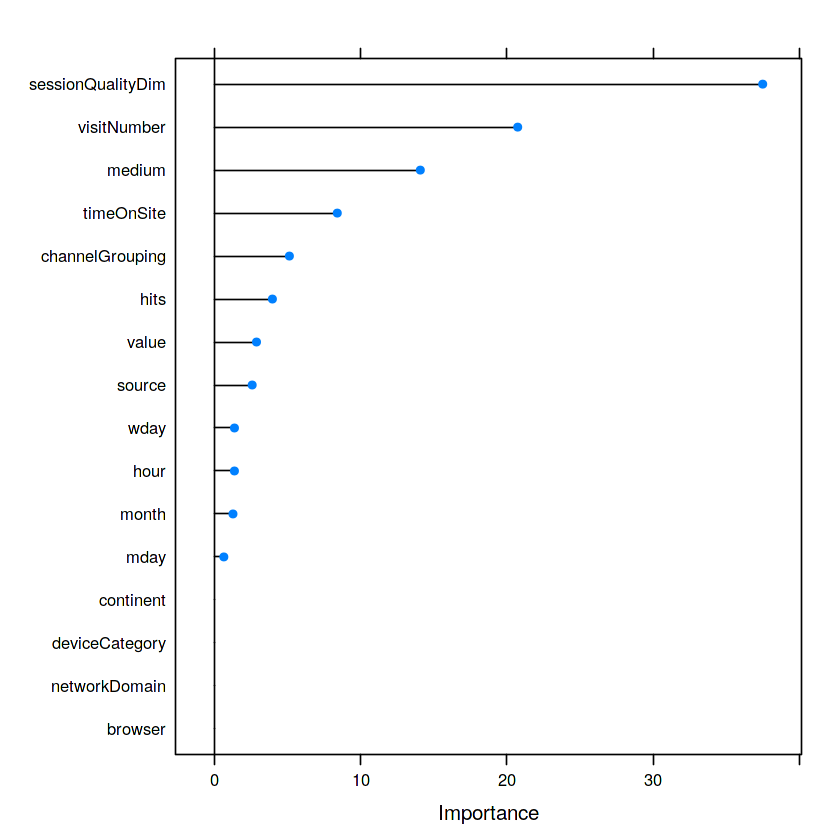

In [77]:
print("Catboost Classification with 10 fold CV...")
#------------------------------
# Splitting the whole dataset into two part: one for model fitting and training, the other for testing
test.data <- imbal.data %>%
    filter(date >= as.Date("2018-05-01"))
dataset <- imbal.data %>%
    filter(date < as.Date("2018-05-01"))

#dataset <- select(dataset, -c("date"))
#test.data <- select(test.data, -c("date"))
#str(dataset)
#str(test.data)
#-------------------------------------
# Normalizing the training set
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim")

pp_norm <- preProcess(dataset[cols.nam], 
                      method = c("scale", "center"))
dataset[cols.nam] <- predict(pp_norm, newdata = dataset[cols.nam])

#------------------------------
# Splitting dataset into training and validation
set.seed(3456)
trainIndex <- createDataPartition(dataset$totalTransactionRevenue, p = .8, 
                                  list = FALSE, 
                                  times = 1)

training <- dataset[ trainIndex,]
validation  <- dataset[-trainIndex,]
#str(training)
#str(validation)
#------------------------------------
# Addressing imbalanced target class
set.seed(1)
training$date <- as.numeric(training$date)
rose.train <- ROSE(totalTransactionRevenue ~ ., data  = training)$data                         
rose.train$date <- as_datetime(rose.train$date)
str(rose.train)
#--------------------------------------
# Encoding categorical variables
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "networkDomain", "source", "medium", "value", "month", "mday", "wday", "hour")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "sessionQualityDim", 
                                          "timeOnSite", "totalTransactionRevenue")])
    return(df)
}
training <- cat.encode.func(rose.train)
validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)                   
#--------------------------------------
# Converting the balanced training and validation set into model-friendly format
y_train <- unlist(training[c('totalTransactionRevenue')])
x_train <- select(training, -c("totalTransactionRevenue"))
y_valid <- unlist(validation[c('totalTransactionRevenue')])
x_valid <- select(validation, -c("totalTransactionRevenue"))
                   
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))

#str(y_train)
#str(y_valid)
#str(x_train)
#str(x_valid)
if(FALSE){
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 10
                           #savePredictions = TRUE,
                           #summaryFunction = twoClassSummary,
                           #classProbs = TRUE
                          )
                   
set.seed(123)
model <- train(x = x_train[, !(colnames(x_train) %in% c("fullVisitorId"))], 
               y = y_train,
                 method = catboost.caret, 
                 trControl = fitControl
                 #verbose = FALSE
              )

#saveRDS(model, "cv_model.rds")
}                  
cv_model <- readRDS("../input/cvmodel/cv_model.rds")
pred <- predict(cv_model, x_valid)
#setdiff(pred_save, x_valid$pred)
# Visualizing the most important attributes                   
#x_valid$pred <- predict(model, x_valid)
#write.csv(x_valid, "x_valid.csv", row.names = F)                 
catImp <- varImp(cv_model, scale = FALSE)
plot(catImp, top = 16)
# Confusion matix for classification and evaluating the model
confusionMatrix(pred, y_valid, positive = "1")
                   
#table(y_valid, x_valid$pred)   
#pred_test <- predict(cv_model, x_test)
#confusionMatrix(pred_test, y_test, positive = "1")

In [96]:
# Removing columns with no useful info, lots of NA or the ones we'll analyze later
imbal.data <- select(dup_train, -c("visitId", "adwordsClickInfo.gclId", "region", "metro", "city", 
                                 "keyword", "referralPath", "adContent", 
              "adwordsClickInfo.slot", "adwordsClickInfo.adNetworkType"))

imbal.data$totalTransactionRevenue[which(is.na(imbal.data$totalTransactionRevenue))] <- 0
#imbal.data$totalTransactionRevenue[which(imbal.data$totalTransactionRevenue != 0)] <- 1
#imbal.data$visitNumberRevenue <- imbal.data$visitNumber*imbal.data$totalTransactionRevenue

imbal.data$month <- factor(month(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$mday <- factor(mday(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$wday <- factor(wday(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$hour <- factor(hour(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data <- select(imbal.data, -c("visitStartTime"))
#imbal.data$totalTransactionRevenue <- log1p(imbal.data$totalTransactionRevenue)
#range(imbal.data$totalTransactionRevenue)
#--------------------------------------------------
# Some type conversions
#rev.class <- vector()
#imbal.data$rev.class <- (rep(NA, nrow(imbal.data)))
#imbal.data$rev.class[which(imbal.data$totalTransactionRevenue != 0)] <- 1
#imbal.data$rev.class[which(imbal.data$totalTransactionRevenue == 0)] <- 0
#fullVisitorId to "factor" type, so it can be fed to ROSE function

cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "networkDomain", "source", "medium", "value", "month", 
              "mday", "wday", "hour")
imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
print("Categorical attributes level reduction...")
#fct_count(imbal.data$browser, sort = TRUE, prop = TRUE)
imbal.data$browser <- fct_lump(imbal.data$browser, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$source <- fct_lump(imbal.data$source, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$networkDomain <- fct_lump(imbal.data$networkDomain, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$operatingSystem <- fct_lump(imbal.data$operatingSystem, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$country <- fct_lump(imbal.data$country, prop = 0.01, w = NULL, other_level = "(Other)")
#-----------------------------------------
# Regression for non-zero revenue customers to predict their revenue
# Code contains repetitions that will be removed when being finalized...
imbal.data <- imbal.data %>% filter(totalTransactionRevenue != 0)
imbal.data$totalTransactionRevenue <- log1p(imbal.data$totalTransactionRevenue)
#str(imbal.data)
#-----------------------------------------
test.data <- imbal.data %>%
    filter(date >= as.Date("2018-05-01"))
dataset <- imbal.data %>%
    filter(date < as.Date("2018-05-01"))

dataset <- select(dataset, -c("date"))
test.data <- select(test.data, -c("date"))
#str(dataset)
#str(test.data)
#-----------------------------------------
print("Normalizing the training set...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim")

pp_norm <- preProcess(dataset[cols.nam], 
                      method = c("scale", "center"))
dataset[cols.nam] <- predict(pp_norm, newdata = dataset[cols.nam])
#------------------------------
# Splitting dataset into training and validation
set.seed(3456)
#str(dataset)
trainIndex <- createDataPartition(dataset$totalTransactionRevenue, p = .8, 
                                  list = FALSE, 
                                  times = 1)

training <- dataset[ trainIndex,]
validation  <- dataset[-trainIndex,]
#str(training)
#str(validation)
#---------------------------------------
set.seed(1)
# Addressing imbalanced numeric class
#rel <- matrix(c(10, 1, 0, 15, 0, 0, 20, 1, 0), ncol = 3, nrow = 3, byrow = TRUE)
#smote.train <- SmoteRegress(totalTransactionRevenue~., training, thr.rel = 0.5, rel = rel, dist = "HEOM",
#                        C.perc = list(10, 1), k=5, repl=FALSE, p = 2)
#-------go with this one for now
rel <- matrix(c(13, 1, 0, 17, 0, 0, 23, 1, 0), ncol = 3, nrow = 3, byrow = TRUE)
smote.train <- SmoteRegress(totalTransactionRevenue~., training, thr.rel = 0.5, rel = rel, dist = "HEOM",
                        C.perc = list(900, 1, 20), k = 5, repl=FALSE, p = 2)
# Some other options...
#smote.train2 <- SmoteRegress(totalTransactionRevenue~., training, dist = "HEOM", C.perc = "extreme")
#smote.train3 <- SmoteRegress(totalTransactionRevenue~., training, dist = "HEOM", C.perc = "balance")

#plot(sort(training$totalTransactionRevenue))
#plot(sort(smote.train$totalTransactionRevenue))
#plot(sort(smote.train2$totalTransactionRevenue))
#plot(sort(smote.train3$totalTransactionRevenue))
#----------------------------------------
# Encoding Cat attributes
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "networkDomain", "source", "medium", "value", "month", "mday", "wday", "hour")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "sessionQualityDim", 
                                          "timeOnSite", "totalTransactionRevenue")])
    return(df)
}
training <- cat.encode.func(smote.train)
validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
#str(test.data)                   
#--------------------------------------
y_train <- unlist(training[c('totalTransactionRevenue')])
x_train <- select(training, -c("totalTransactionRevenue"))
y_valid <- unlist(validation[c('totalTransactionRevenue')])
x_valid <- select(validation, -c("totalTransactionRevenue"))
#str(y_train)
#str(y_valid)
#str(x_train)
#str(x_valid)
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
#str(y_test)
#str(x_test)
#----------------------------------------
if(FALSE){
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 10
                           #savePredictions = TRUE,
                           #summaryFunction = twoClassSummary,
                           #classProbs = TRUE
                          )
                   
set.seed(123)
reg.model <- train(x = x_train[, !(colnames(x_train) %in% c("fullVisitorId"))], 
               y = y_train,
                 method = catboost.caret, 
                 trControl = fitControl
              )
}
#saveRDS(reg.model, "reg.model.rds")
reg_model <- readRDS("../input/regmodel/reg.model.rds")
pred <- predict(reg_model, x_valid)
#setdiff(pred_save, x_valid$pred)
                   
#write.csv(x_valid, "x_valid.csv", row.names = F)                 

pred <- reg_model %>% predict(x_test)
print("Model performance...") 
# (a) Prediction error, RMSE
print(RMSE(pred, y_test))
# (b) R-square
print(R2(pred, y_test))

[1] "Categorical attributes level reduction..."
[1] "Normalizing the training set..."
[1] "Model performance..."
[1] 1.922564
[1] 8.498484e-05


In [ ]:
# Removing columns with no useful info, lots of NA or the ones we'll analyze later
imbal.data <- select(dup_train, -c("visitId", "adwordsClickInfo.gclId", "region", "metro", "city", 
                                 "keyword", "referralPath", "adContent", 
              "adwordsClickInfo.slot", "adwordsClickInfo.adNetworkType", "visitStartTime"))

imbal.data$totalTransactionRevenue[which(is.na(imbal.data$totalTransactionRevenue))] <- 0
imbal.data$totalTransactionRevenue[which(imbal.data$totalTransactionRevenue != 0)] <- 1
#imbal.data$visitNumberRevenue <- imbal.data$visitNumber*imbal.data$totalTransactionRevenue
#--------------------------------------------------
# Some type conversions
cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "networkDomain", "source", "medium", "value", "totalTransactionRevenue")
imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
print("Categorical attributes level reduction...")
#fct_count(imbal.data$browser, sort = TRUE, prop = TRUE)
imbal.data$browser <- fct_lump(imbal.data$browser, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$source <- fct_lump(imbal.data$source, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$networkDomain <- fct_lump(imbal.data$networkDomain, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$operatingSystem <- fct_lump(imbal.data$operatingSystem, prop = 0.01, w = NULL, other_level = "(Other)")

imbal.data$country <- fct_lump(imbal.data$country, prop = 0.01, w = NULL, other_level = "(Other)")
#------------------------------------
# creatTimeSlice: time series cross validation
test.data <- imbal.data %>%
    filter(date >= as.Date("2018-05-01"))
dataset <- imbal.data %>%
    filter(date < as.Date("2018-05-01"))

#str(dataset)
#str(test.data)
#-------------------------------------
print("Normalizing the training set...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim")

pp_norm <- preProcess(dataset[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
dataset[cols.nam] <- predict(pp_norm, newdata = dataset[cols.nam])
#-------------------------------------
#Data split
training <- dataset %>%
    filter(date < as.Date("2018-01-01"))
validation <- dataset %>%
    filter(date >= as.Date("2018-01-01"))

#range(training$date)
#range(validation$date)
#str(training)
#str(validation)
#------------------------------------
# Addressing imbalanced class
set.seed(1)
training$date <- as.numeric(training$date)

rose.train <- ROSE(totalTransactionRevenue ~ ., data  = training)$data                         

rose.train$date <- lubridate::as_datetime(rose.train$date)
                        
#table(rose.train$totalTransactionRevenue) 
#str(rose.train)
#-----------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "sessionQualityDim", 
                                          "timeOnSite", "totalTransactionRevenue", "date")])
    return(df)
}
training <- cat.encode.func(rose.train)
validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
#-------------------------------------
y_train <- unlist(training[c('totalTransactionRevenue')])
x_train <- select(training, -c("totalTransactionRevenue"))
y_valid <- unlist(validation[c('totalTransactionRevenue')])
x_valid <- select(validation, -c("totalTransactionRevenue"))

#str(y_train)
#str(y_valid)
#str(x_train)
#str(x_valid)
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
#str(y_test)
#str(x_test)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- training %>% 
mutate(month = format(date, "%m"), year = format(date, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
head(temp)
max(unique(temp$group.index))
#str(temp)
#-------------------------------------------
# Creating time slices
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 20, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
#time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}
#str(temp)
#-------------------------------------------
fitControl <- trainControl(## createTimeSlice
                           method = "timeslice",
                           #sampling = "rose",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)                           
)
                   
set.seed(123)
grid <- expand.grid(depth = c(5,6,7),
                    learning_rate = c(0.2,0.1,0.05),
                    iterations = c(50,100,200),
                    l2_leaf_reg = 3,
                    rsm = c(0.8,1.0),
                    border_count = c(64,128,255)) 
                   
model <- train(x = x_train[, !(colnames(x_train) %in% c("date", "fullVisitorId"))], 
               y = y_train,
                 method = catboost.caret, 
                 trControl = fitControl,
                  tuneGrid = grid,
                   tuneLength = 3,
                  task_type = "CPU",
                  thread_count = 4
                
              )

saveRDS(model, "ts.model.rds")
                   
pred <- predict(model, x_valid)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 20)
                   
confusionMatrix(pred, y_valid, positive = "1")
                   
table(y_valid, pred) 
                   
pred_test <- predict(model, x_test)
confusionMatrix(pred_test, y_test, positive = "1")

In [ ]:
if(FALSE){
set.seed(131)
groups <- sort(sample(letters[1:4], size = 20, replace = TRUE))
sample(letters[1:4], size = 20, replace = TRUE)
groups <- sort(format(dup_train$date, "%Y-%m"))
groups
table(groups)
folds <- groupKFold(groups, k = 10)

str(folds)

lapply(folds, function(x, y) table(y[x]), y = groups)
#--------------------------------
group_cv <- function(x, k = length(unique(x))) {
  dat <- data.frame(index = seq(along = x), group = x)
  groups <- data.frame(group = unique(dat$group))
  group_folds <- createFolds(groups$group, returnTrain = TRUE, k = k)
  group_folds <- lapply(group_folds, function(x, y) y[x,,drop = FALSE], y = groups)
  dat_folds <- lapply(group_folds, function(x, y) merge(x, y), y = dat)
  lapply(dat_folds, function(x) sort(x$index))
}

groups <- c(1, 1, 1, 2, 2, 2, 3, 3, 3, 3)
groups
table(groups)
set.seed(242)
folds <- group_cv(groups)
folds
## check: 
for_mod <- lapply(folds, function(x, y) y[x], y = groups)
holdout <- lapply(folds, function(x, y) y[-unique(x)], y = groups)
for(i in seq(along = folds)) {
  if(any(unique(for_mod[[i]]) %in% unique(holdout[[i]])))
    cat("didn't work!")
}

## Test with more groups and smaller # folds
set.seed(91906)
other_groups <- sort(sample(letters[1:15], size = 50, replace = TRUE))
folds_1 <- group_cv(other_groups, k = 5)
table(other_groups)
folds_1
for_mod <- lapply(folds_1, function(x, y) y[x], y = other_groups)
holdout <- lapply(folds_1, function(x, y) y[-unique(x)], y = other_groups)
for(i in seq(along = folds_1)) {
  if(any(unique(for_mod[[i]]) %in% unique(holdout[[i]])))
    cat("didn't work!")
}

library(caret)
x <- rep(1:12, each = 30)
folds <- groupKFold(x, k = 12)
folds
folds2 <- lapply(folds, function(x) lapply(1:10, function(i) sample(x, size = length(x), replace = TRUE)))
folds2
folds2 <- unlist(folds2 , recursive = FALSE, use.names = TRUE)
}